In [ ]:
# Import necessary libraries
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
# import os
# os.environ['R_HOME'] = 'C:\\Program Files\\R\\R-4.2.2'  # Replace with your R path
# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri


: 

In [ ]:
# Setting display to view all columns
pd.set_option('display.max_columns', 40)

In [ ]:
# Ignore Warnings
warnings.filterwarnings("ignore")

In [ ]:
# Code to loop over all phase files
# Mechanism to save results from different phases
# Mechanism to combine results from different phases for an entire location

In [ ]:
# Reading Individual Level Data
ind_data = pd.read_csv("D:\\DOWNLOADS_FOR_D_DRIVE_REAL_TIME\\HPSDATA\\Phase 4.2\\HPS_Phase4-2Cycle09_PUF_CSV(Aug20-Sep16)2024\\hps_04_02_09_puf.csv")

#Print first few rows
ind_data

,SCRAM,CYCLE,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,RHISPANIC,AHISPANIC,RRACE,ARACE,EEDUC,AEDUC,MS,EGENID_BIRTH,AGENID_BIRTH,SEXUAL_ORIENTATION_RV,THHLD_NUMPER,...,TRANSPORT12,ACCESS_TRANSP,NEEDS_TRANSP1,NEEDS_TRANSP2,NEEDS_TRANSP3,NEEDS_TRANSP4,NEEDS_TRANSP5,NEEDS_TRANSP6,NEEDS_TRANSP7,HOME_INTERNET,MOBILE_INTERNET,REDUCED_INT1,REDUCED_INT2,REDUCED_INT3,REDUCED_INT4,REDUCED_INT5,REDUCED_INT6,CANCEL_INTERNET,SOCIAL1,SOCIAL2
0,P090000001,9,16,NaN,4,346.116733,661.962433,1957,2,1,2,1,2,7,2,1,1,2,4,2,...,-99,1,-88,-88,-88,-88,-88,-88,-88,1,1,-99,-99,-99,-99,-99,1,-88,2,5
1,P090000002,9,25,NaN,1,2336.708636,9032.515483,1972,2,2,2,1,1,7,2,1,2,2,2,5,...,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,5,5
2,P090000003,9,47,NaN,2,1755.398703,3307.507300,1968,2,1,2,1,2,5,2,5,2,2,2,2,...,-99,1,-88,-88,-88,-88,-88,-88,-88,1,1,-99,-99,-99,-99,-99,1,-88,2,4
3,P090000004,9,48,19100.0,2,1455.722342,1390.330986,1970,2,1,2,1,2,6,2,3,2,2,2,1,...,-99,1,-88,-88,-88,-88,-88,-88,-88,1,1,-99,-99,-99,-99,-99,1,-88,2,4
4,P090000005,9,12,NaN,2,19945.968831,19205.417835,1958,2,1,2,2,2,3,2,3,1,2,2,1,...,-99,1,-88,-88,-88,-88,-88,-88,-88,1,1,-99,-99,-99,-99,-99,1,-88,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51275,P090051276,9,6,31080.0,4,4619.636224,17430.256056,1971,2,2,2,1,2,4,2,1,2,2,2,4,...,-99,1,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88,1,5
51276,P090051277,9,55,NaN,3,1312.624800,2551.497708,1957,2,2,2,1,2,6,2,1,1,2,2,2,...,-99,1,-88,-88,-88,-88,-88,-88,-88,1,1,-99,-99,-99,-99,-99,1,-88,2,3
51277,P090051278,9,37,NaN,2,2135.741472,4201.364337,1986,2,1,2,1,2,7,2,1,2,2,2,4,...,-99,1,-88,-88,-88,-88,-88,-88,-88,1,1,-99,-99,-99,-99,-99,1,-88,2,3
51278,P090051279,9,51,NaN,2,203.416645,383.315397,1949,2,1,2,1,2,7,2,1,1,2,2,2,...,-99,1,-88,-88,-88,-88,-88,-88,-88,1,1,-99,-99,-99,-99,-99,1,-88,1,5


In [ ]:
# Filtering dataset based on MSA and STATE
MSACODE = None
STATECODE = 34
if MSACODE is not None:
    ind_data = ind_data[(ind_data['EST_MSA'] == MSACODE) & (ind_data['EST_ST'] == STATECODE)]
else:
    ind_data = ind_data[(ind_data['EST_ST'] == STATECODE)]

# Calculating age based on the year the survey was conducted in
ind_data['AGE'] = 2024 - ind_data['TBIRTH_YEAR']

# Filtering dataset based on variables of interest
variables_of_interest = ["EST_ST","EST_MSA", "MS", "RRACE", "TWDAYS", "EEDUC", "KINDWORK", "THHLD_NUMPER", "INCOME", "EGENID_BIRTH", "AGE", "RHISPANIC", "ANYWORK", "TWDAYS_RESP"]
ind_data = ind_data[variables_of_interest]

# View datframe
ind_data


,EST_ST,EST_MSA,MS,RRACE,TWDAYS,EEDUC,KINDWORK,THHLD_NUMPER,INCOME,EGENID_BIRTH,AGE,RHISPANIC,ANYWORK,TWDAYS_RESP
39,34,35620.0,2,1,4,3,-88,1,5,2,83,1,2,-88
96,34,37980.0,1,1,3,3,2,5,4,2,38,1,1,3
135,34,35620.0,1,1,4,4,-88,5,6,2,54,1,2,-88
186,34,35620.0,1,1,4,3,2,3,-88,2,47,2,1,-88
215,34,37980.0,3,1,4,4,-88,1,-88,2,75,1,2,-88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50989,34,35620.0,1,1,4,3,2,3,4,1,54,2,1,-88
51036,34,37980.0,1,1,4,6,3,3,6,2,40,1,1,-88
51063,34,35620.0,1,1,1,5,2,2,4,2,55,1,1,1
51250,34,35620.0,2,1,4,6,-88,1,5,1,72,1,2,-88


In [312]:
# Checking for unique occurrences for chosen constraints
print(sorted(ind_data['AGE'].unique()))
print(sorted(ind_data['EEDUC'].unique()))
print(sorted(ind_data['EGENID_BIRTH'].unique()))
print(sorted(ind_data['KINDWORK'].unique()))
print(sorted(ind_data['INCOME'].unique()))
print(sorted(ind_data['MS'].unique()))
print(sorted(ind_data['THHLD_NUMPER'].unique()))
print(sorted(ind_data['TWDAYS'].unique()))

# Replacing -99 and -88 codes with NA to treat them as missing
ind_data['EEDUC'].replace([-99, -88], pd.NA, inplace=True)
ind_data['TWDAYS'].replace([-99, -88], pd.NA, inplace=True)
ind_data['KINDWORK'].replace([-99, -88], pd.NA, inplace=True)
ind_data['INCOME'].replace([-99, -88], pd.NA, inplace=True)
ind_data['MS'].replace([-99, -88], pd.NA, inplace=True)

# Dropping rows with NA values, and filtering data to keep individuals aged 25 and above, and who are employed
ind_data.dropna(inplace=True)
ind_data = ind_data[ind_data['AGE'] >= 25]
ind_data = ind_data[ind_data['ANYWORK'] == 1]

# Checking for unique occurrences for chosen constraints after filtering
print(sorted(ind_data['AGE'].unique()))
print(sorted(ind_data['EEDUC'].unique()))
print(sorted(ind_data['EGENID_BIRTH'].unique()))
print(sorted(ind_data['KINDWORK'].unique()))
print(sorted(ind_data['INCOME'].unique()))
print(sorted(ind_data['MS'].unique()))
print(sorted(ind_data['THHLD_NUMPER'].unique()))
print(sorted(ind_data['TWDAYS'].unique()))

ind_data

[np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(71), np.int64(72), np.int64(73), np.int64(74), np.int64(75), np.int64(76), np.int64(77), np.int64(78), np.int64(79), np.int64(80), np.int64(81), np.int64(82), np.int64(83), np.int64(84), np.int64(85), np.int64(88)]
[np.int64(1), np.int64(2), np.int

,EST_ST,EST_MSA,MS,RRACE,TWDAYS,EEDUC,KINDWORK,THHLD_NUMPER,INCOME,EGENID_BIRTH,AGE,RHISPANIC,ANYWORK,TWDAYS_RESP
96,34,37980.0,1,1,3,3,2,5,4,2,38,1,1,3
224,34,35620.0,1,1,4,7,3,2,7,1,67,1,1,-88
279,34,35620.0,1,1,4,6,2,2,2,1,72,2,1,-88
552,34,37980.0,1,1,1,5,2,2,6,1,69,1,1,1
598,34,35620.0,1,1,2,6,2,3,8,2,33,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50923,34,35620.0,3,2,4,5,2,3,3,2,41,2,1,-88
50960,34,37980.0,1,3,1,5,4,4,8,1,49,1,1,4
50989,34,35620.0,1,1,4,3,2,3,4,1,54,2,1,-88
51036,34,37980.0,1,1,4,6,3,3,6,2,40,1,1,-88


In [313]:
# Fixed arrays
brks = [25, 30, 35, 40, 45, 50, 55, 60, 62, 65, 67, 70, 75, 80, 85, float('inf')]
labs = [
    "25 to 29 years", "30 to 34 years", "35 to 39 years", "40 to 44 years", "45 to 49 years",
    "50 to 54 years", "55 to 59 years", "60 and 61 years", "62 to 64 years", "65 and 66 years",
    "67 to 69 years", "70 to 74 years", "75 to 79 years", "80 to 84 years", "85 years and over"
]

# Input unique values
unique_values = ind_data['AGE'].unique()

# Convert unique_values to a set for faster lookup
unique_values_set = set(unique_values)

# Age category dictionary
age_cat_dict = {
    "25 to 29 years": [25, 26, 27, 28, 29],
    "30 to 34 years": [30, 31, 32, 33, 34],
    "35 to 39 years": [35, 36, 37, 38, 39],
    "40 to 44 years": [40, 41, 42, 43, 44],
    "45 to 49 years": [45, 46, 47, 48, 49],
    "50 to 54 years": [50, 51, 52, 53, 54],
    "55 to 59 years": [55, 56, 57, 58, 59],
    "60 and 61 years": [60, 61],
    "62 to 64 years": [62, 63, 64],
    "65 and 66 years": [65, 66],
    "67 to 69 years": [67, 68, 69],
    "70 to 74 years": [70, 71, 72, 73, 74],
    "75 to 79 years": [75, 76, 77, 78, 79],
    "80 to 84 years": [80, 81, 82, 83, 84],
    "85 years and over": list(range(85, 200))
}

# Create new bins and labels based on the presence of unique values
new_brks = [brks[0]]
new_labs = []

for label, ages in age_cat_dict.items():
    # Check if there are any values in the current age range
    if any(age in unique_values_set for age in ages):
        # Append the end value of the current bin
        if label != "85 years and over":
            new_brks.append(brks[len(new_labs) + 1])
        else:
            new_brks.append(float('inf'))
        new_labs.append(label)

# Output the updated bins and labels
print("Updated Bins:", new_brks)
print("Updated Labels:", new_labs)


Updated Bins: [25, 30, 35, 40, 45, 50, 55, 60, 62, 65, 67, 70, 75, 80, 85]
Updated Labels: ['25 to 29 years', '30 to 34 years', '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years', '60 and 61 years', '62 to 64 years', '65 and 66 years', '67 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years']


In [ ]:
# Enable the pandas to R dataframe conversion
pandas2ri.activate()

# Load the R script containing the function
r = robjects.r
r.source('age_sexcons.R')  # Replace 'your_script.R' with the path to your R script

# Reference the function from the R script
process_acs_age_sex_data = robjects.globalenv['process_acs_age_sex_data']

# Define inputs
brks = robjects.FloatVector(new_brks)
labs = robjects.StrVector(new_labs)
statename = "NJ"
countyname = "Middlesex"

# Call the R function from Python
result = process_acs_age_sex_data(brks, labs, statename, countyname)

# Convert the result to a Pandas DataFrame
import pandas as pd
con_age_sex_df = pandas2ri.ri2py(result)

# Display the result
print(con_age_sex_df)


In [314]:
# Encoding/ recategorizing constraints
ind_data['AGE'] = pd.cut(ind_data['AGE'], bins=new_brks, labels=new_labs, right=False)
ind_data['EGENID_BIRTH'] = ind_data['EGENID_BIRTH'].replace({1: 'Male', 2: 'Female'})
ind_data['EEDUC'] = ind_data['EEDUC'].replace({1: 'Less than high school', 2:'Some high School',3: 'High school graduate or equivalent (for example GED)', 4: 'Some college, but degree not received or is in progress', 5: 'Associate’s degree (for example AA, AS)', 6: "Bachelor's degree (for example BA, BS, AB)", 7: "Graduate degree (for example master's, professional, doctorate)"})
ind_data['KINDWORK'] = ind_data['KINDWORK'].replace({1: 'Government', 2: 'Private company', 3: 'Non-profit organization including tax exempt and charitable organizations', 4: 'Self-employed', 5: 'Working in a family business'})
ind_data['TWDAYS'] = ind_data['TWDAYS'].replace({1: 'Yes, for 1-2 days', 2: 'Yes, for 3-4 days', 3: 'Yes, for 5 or more days', 4: 'No'})
ind_data['INCOME'] = ind_data['INCOME'].replace({1: 'Less than $25,000', 2: '$25,000 - $34,999', 3: '$35,000 - $49,999', 4: '$50,000 - $74,999', 5: '$75,000 - $99,999', 6: '$100,000 - $149,999', 7: '$150,000 - $199,999', 8: '$200,000 and above'})
ind_data['MS'] = ind_data['MS'].replace({1: 'Now married', 2: 'Widowed', 3: 'Divorced', 4: 'Separated', 5: 'Never married'})

# Creating subsets of the data
ind_full = ind_data[["EGENID_BIRTH", "AGE", "EEDUC", "KINDWORK", "INCOME", "MS", "THHLD_NUMPER", "TWDAYS"]]
ind_data = ind_data[["EST_ST", "EGENID_BIRTH", "AGE", "EEDUC", "KINDWORK", "MS", "THHLD_NUMPER", "INCOME", "TWDAYS"]]

# Checking for unique occurrences for chosen constraints after recategorizing
print(sorted(ind_data['AGE'].unique()))
print(sorted(ind_data['EEDUC'].unique()))
print(sorted(ind_data['EGENID_BIRTH'].unique()))
print(sorted(ind_data['KINDWORK'].unique()))
print(sorted(ind_data['INCOME'].unique()))
print(sorted(ind_data['TWDAYS'].unique()))

ind_data


['25 to 29 years', '30 to 34 years', '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years', '60 and 61 years', '62 to 64 years', '65 and 66 years', '67 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years']
['Associate’s degree (for example AA, AS)', "Bachelor's degree (for example BA, BS, AB)", "Graduate degree (for example master's, professional, doctorate)", 'High school graduate or equivalent (for example GED)', 'Less than high school', 'Some college, but degree not received or is in progress', 'Some high School']
['Female', 'Male']
['Government', 'Non-profit organization including tax exempt and charitable organizations', 'Private company', 'Self-employed', 'Working in a family business']
['$100,000 - $149,999', '$150,000 - $199,999', '$200,000 and above', '$25,000 - $34,999', '$35,000 - $49,999', '$50,000 - $74,999', '$75,000 - $99,999', 'Less than $25,000']
['No', 'Yes, for 1-2 days', 'Yes, for 3-4 days', 'Yes, for 5 or more days']

,EST_ST,EGENID_BIRTH,AGE,EEDUC,KINDWORK,MS,THHLD_NUMPER,INCOME,TWDAYS
96,34,Female,35 to 39 years,High school graduate or equivalent (for exampl...,Private company,Now married,5,"$50,000 - $74,999","Yes, for 5 or more days"
224,34,Male,67 to 69 years,"Graduate degree (for example master's, profess...",Non-profit organization including tax exempt a...,Now married,2,"$150,000 - $199,999",No
279,34,Male,70 to 74 years,"Bachelor's degree (for example BA, BS, AB)",Private company,Now married,2,"$25,000 - $34,999",No
552,34,Male,67 to 69 years,"Associate’s degree (for example AA, AS)",Private company,Now married,2,"$100,000 - $149,999","Yes, for 1-2 days"
598,34,Female,30 to 34 years,"Bachelor's degree (for example BA, BS, AB)",Private company,Now married,3,"$200,000 and above","Yes, for 3-4 days"
...,...,...,...,...,...,...,...,...,...
50923,34,Female,40 to 44 years,"Associate’s degree (for example AA, AS)",Private company,Divorced,3,"$35,000 - $49,999",No
50960,34,Male,45 to 49 years,"Associate’s degree (for example AA, AS)",Self-employed,Now married,4,"$200,000 and above","Yes, for 1-2 days"
50989,34,Male,50 to 54 years,High school graduate or equivalent (for exampl...,Private company,Now married,3,"$50,000 - $74,999",No
51036,34,Female,40 to 44 years,"Bachelor's degree (for example BA, BS, AB)",Non-profit organization including tax exempt a...,Now married,3,"$100,000 - $149,999",No


In [ ]:
con_age = 

In [315]:
con_age = pd.read_csv("con_age.csv")
con_sex= pd.read_csv("con_sex.csv")
con_edu = pd.read_csv("con_edu.csv")
con_work = pd.read_csv("con_work.csv")
con_income = pd.read_csv("con_income.csv")
con_marraige = pd.read_csv("con_marraige.csv")

In [316]:
# Checking the Total sums of each constraint
sum_con_age = con_age.sum(numeric_only=True).sum()
sum_con_sex = con_sex.sum(numeric_only=True).sum()
sum_con_edu = con_edu.sum(numeric_only=True).sum()
sum_con_work = con_work.sum(numeric_only=True).sum()
sum_con_income = con_income.sum(numeric_only=True).sum()
print("Sum of age:{}".format(sum_con_age))
print("Sum of sex:{}.".format(sum_con_sex))
print("Sum of education:{}".format(sum_con_edu))
print("Sum of work:{}".format(sum_con_work))
print("Sum of income:{}".format(sum_con_income))

Sum of age:582618
Sum of sex:575260.0.
Sum of education:598110.0
Sum of work:436970.0
Sum of income:320079


In [317]:
# Compute total work counts for each row
total_income_counts = con_income.sum(axis=1)

# Define the adjustment and correction function
def adjust_and_correct(df, target_totals):
    # Compute the initial proportions
    proportions = df.div(df.sum(axis=1), axis=0)
    
    # Apply target totals using proportions
    adjusted_values = proportions.mul(target_totals, axis=0)
    rounded_values = adjusted_values.round()
    
    # Efficiently correct residuals
    residuals = target_totals - rounded_values.sum(axis=1)
    for idx in residuals[residuals != 0].index:
        sign = np.sign(residuals[idx])
        row_proportions = proportions.loc[idx]
        sorted_indices = row_proportions.sort_values(ascending=False).index
        for col in sorted_indices:
            if sign == 1 and residuals[idx] > 0:
                max_add = target_totals[idx] - rounded_values.loc[idx].sum()
                add_value = min(max_add, residuals[idx])
                rounded_values.loc[idx, col] += add_value
                residuals[idx] -= add_value
            elif sign == -1 and residuals[idx] < 0:
                max_sub = rounded_values.loc[idx, col]
                sub_value = min(max_sub, -residuals[idx])
                rounded_values.loc[idx, col] -= sub_value
                residuals[idx] += sub_value
            if residuals[idx] == 0:
                break
    
    # Validation (optional but recommended)
    validation_passed = (rounded_values.sum(axis=1) == target_totals).all()
    return {
        'rounded_values': rounded_values,
        'validation_passed': validation_passed
    }

# Apply the function to your datasets
results_edu = adjust_and_correct(con_edu, total_income_counts)
results_age = adjust_and_correct(con_age, total_income_counts)
results_sex = adjust_and_correct(con_sex, total_income_counts)
results_work = adjust_and_correct(con_work, total_income_counts)

# Output the results to check
print("Adjusted and Corrected Education Data:")
print(results_edu['rounded_values'])
print("\nAdjusted and Corrected Age Data:")
print(results_age['rounded_values'])
print("\nAdjusted and Corrected Sex Data:")
print(results_sex['rounded_values'])
print("\nAdjusted and Corrected Work Data:")
print(results_work['rounded_values'])

Adjusted and Corrected Education Data:
     Less than high school  Some high school  \
0                      4.0               1.0   
1                     23.0              15.0   
2                     18.0              77.0   
3                     15.0              15.0   
4                      9.0               1.0   
..                     ...               ...   
561                    4.0              20.0   
562                    2.0              37.0   
563                   66.0              50.0   
564                    7.0               3.0   
565                    1.0               4.0   

     High school graduate or equivalent (for example GED)  \
0                                                242.0      
1                                                185.0      
2                                                 97.0      
3                                                256.0      
4                                                 60.0      
..                

In [318]:
# Assign corrected values back to the original dataframes
con_age = results_age['rounded_values']
con_sex = results_sex['rounded_values']
con_edu = results_edu['rounded_values']
con_work = results_work['rounded_values']

# Sum the total values of the different corrected constraints
sum_con_age = con_age.values.sum()
sum_con_sex = con_sex.values.sum()
sum_con_edu = con_edu.values.sum()
sum_con_work = con_work.values.sum()

# Display the total sum of corrected constraints
print("Total Sum of Corrected Age Constraints:")
print(sum_con_age)
print("\nTotal Sum of Corrected Sex Constraints:")
print(sum_con_sex)
print("\nTotal Sum of Corrected Education Constraints:")
print(sum_con_edu)
print("\nTotal Sum of Corrected Work Constraints:")
print(sum_con_work)


# Compare row sums of different corrected constraints
print("\nRow sums comparison between corrected constraints:")
print((con_income.sum(axis=1) == con_age.sum(axis=1)).all())
print((con_income.sum(axis=1) == con_sex.sum(axis=1)).all())
print((con_income.sum(axis=1) == con_work.sum(axis=1)).all())
print((con_income.sum(axis=1) == con_edu.sum(axis=1)).all())


Total Sum of Corrected Age Constraints:
320079.0

Total Sum of Corrected Sex Constraints:
320079.0

Total Sum of Corrected Education Constraints:
320079.0

Total Sum of Corrected Work Constraints:
320079.0

Row sums comparison between corrected constraints:
True
True
True
True


In [319]:
# Check age constraint
con_age.head()

,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years
0,3.0,1.0,145.0,28.0,159.0,139.0,85.0,14.0,28.0,40.0,1.0,30.0,37.0,19.0
1,30.0,38.0,158.0,89.0,31.0,60.0,50.0,15.0,74.0,24.0,65.0,89.0,21.0,1.0
2,95.0,167.0,41.0,1.0,15.0,51.0,65.0,17.0,45.0,32.0,76.0,1.0,15.0,1.0
3,54.0,42.0,66.0,31.0,42.0,111.0,240.0,46.0,47.0,15.0,32.0,43.0,20.0,46.0
4,13.0,33.0,1.0,37.0,13.0,38.0,43.0,1.0,14.0,1.0,7.0,15.0,43.0,28.0


In [320]:
# Check sex constraint
con_sex.head()

,Male,Female
0,200.0,529.0
1,404.0,341.0
2,276.0,346.0
3,435.0,400.0
4,115.0,172.0


In [321]:
# Check education constraint
con_edu.head()

,Less than high school,Some high school,High school graduate or equivalent (for example GED),"Some college, but degree not received or is in progress","Associate’s degree (for example AA, AS)","Bachelor's degree (for example BA, BS, AB)","Graduate degree (for example master's, professional, doctorate)"
0,4.0,1.0,242.0,84.0,33.0,267.0,98.0
1,23.0,15.0,185.0,133.0,54.0,259.0,76.0
2,18.0,77.0,97.0,81.0,27.0,205.0,117.0
3,15.0,15.0,256.0,176.0,115.0,200.0,58.0
4,9.0,1.0,60.0,83.0,20.0,75.0,39.0


In [322]:
# Check work constraint
con_work.head()

,Government,Private company,Non-profit organization including tax exempt and charitable organizations,Self-employed,Working in a family business
0,255.0,428.0,21.0,25.0,0.0
1,132.0,400.0,76.0,137.0,0.0
2,166.0,437.0,17.0,2.0,0.0
3,86.0,649.0,85.0,15.0,0.0
4,86.0,198.0,1.0,2.0,0.0


In [323]:
# Check income constraint
con_income.head()

,"Less than $25,000","$25,000 - $34,999","$35,000 - $49,999","$50,000 - 74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 - $199,999","$200,000 and above"
0,8,54,151,18,213,167,71,47
1,39,4,29,121,63,232,88,169
2,33,30,129,50,18,216,100,46
3,23,39,34,81,123,85,201,249
4,44,25,22,29,25,85,13,44


In [324]:
# Create constraint dataframe by combining all constraints
cons = pd.concat([con_age, con_sex, con_edu, con_work, con_income], axis=1)

# # Reading the CSV file containing block IDs
# blockids = pd.read_csv("BlockIDs.csv")

# # Combining the block IDs with the constraints data
# cons = pd.concat([blockids, cons], axis=1)

# Display the resulting DataFrame
cons.head()

,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,Male,Female,Less than high school,Some high school,High school graduate or equivalent (for example GED),"Some college, but degree not received or is in progress","Associate’s degree (for example AA, AS)","Bachelor's degree (for example BA, BS, AB)","Graduate degree (for example master's, professional, doctorate)",Government,Private company,Non-profit organization including tax exempt and charitable organizations,Self-employed,Working in a family business,"Less than $25,000","$25,000 - $34,999","$35,000 - $49,999","$50,000 - 74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 - $199,999","$200,000 and above"
0,3.0,1.0,145.0,28.0,159.0,139.0,85.0,14.0,28.0,40.0,1.0,30.0,37.0,19.0,200.0,529.0,4.0,1.0,242.0,84.0,33.0,267.0,98.0,255.0,428.0,21.0,25.0,0.0,8,54,151,18,213,167,71,47
1,30.0,38.0,158.0,89.0,31.0,60.0,50.0,15.0,74.0,24.0,65.0,89.0,21.0,1.0,404.0,341.0,23.0,15.0,185.0,133.0,54.0,259.0,76.0,132.0,400.0,76.0,137.0,0.0,39,4,29,121,63,232,88,169
2,95.0,167.0,41.0,1.0,15.0,51.0,65.0,17.0,45.0,32.0,76.0,1.0,15.0,1.0,276.0,346.0,18.0,77.0,97.0,81.0,27.0,205.0,117.0,166.0,437.0,17.0,2.0,0.0,33,30,129,50,18,216,100,46
3,54.0,42.0,66.0,31.0,42.0,111.0,240.0,46.0,47.0,15.0,32.0,43.0,20.0,46.0,435.0,400.0,15.0,15.0,256.0,176.0,115.0,200.0,58.0,86.0,649.0,85.0,15.0,0.0,23,39,34,81,123,85,201,249
4,13.0,33.0,1.0,37.0,13.0,38.0,43.0,1.0,14.0,1.0,7.0,15.0,43.0,28.0,115.0,172.0,9.0,1.0,60.0,83.0,20.0,75.0,39.0,86.0,198.0,1.0,2.0,0.0,44,25,22,29,25,85,13,44


In [325]:
# Creating dummy variables for each column with 0 and 1 representation
cat_age = pd.get_dummies(ind_data['AGE'], prefix='AGE', drop_first=False).astype(int)
cat_sex = pd.get_dummies(ind_data['EGENID_BIRTH'], prefix='EGENID_BIRTH', drop_first=False).astype(int)
cat_edu = pd.get_dummies(ind_data['EEDUC'], prefix='EEDUC', drop_first=False).astype(int)
cat_work = pd.get_dummies(ind_data['KINDWORK'], prefix='KINDWORK', drop_first=False).astype(int)
cat_income = pd.get_dummies(ind_data['INCOME'], prefix='INCOME', drop_first=False).astype(int)

# Getting the dimensions of each dummy matrix
print(cat_age.shape)
print(cat_sex.shape)
print(cat_edu.shape)
print(cat_work.shape)
print(cat_income.shape)

(369, 14)
(369, 2)
(369, 7)
(369, 5)
(369, 8)


In [326]:
# Combine the dummy matrices horizontally (similar to `cbind()` in R)
ind_cat = pd.concat([cat_age, cat_sex, cat_edu, cat_work, cat_income], axis=1)

# Display the first few rows of the resulting DataFrame
ind_cat.head()

,AGE_25 to 29 years,AGE_30 to 34 years,AGE_35 to 39 years,AGE_40 to 44 years,AGE_45 to 49 years,AGE_50 to 54 years,AGE_55 to 59 years,AGE_60 and 61 years,AGE_62 to 64 years,AGE_65 and 66 years,AGE_67 to 69 years,AGE_70 to 74 years,AGE_75 to 79 years,AGE_80 to 84 years,EGENID_BIRTH_Female,EGENID_BIRTH_Male,"EEDUC_Associate’s degree (for example AA, AS)","EEDUC_Bachelor's degree (for example BA, BS, AB)","EEDUC_Graduate degree (for example master's, professional, doctorate)",EEDUC_High school graduate or equivalent (for example GED),EEDUC_Less than high school,"EEDUC_Some college, but degree not received or is in progress",EEDUC_Some high School,KINDWORK_Government,KINDWORK_Non-profit organization including tax exempt and charitable organizations,KINDWORK_Private company,KINDWORK_Self-employed,KINDWORK_Working in a family business,"INCOME_$100,000 - $149,999","INCOME_$150,000 - $199,999","INCOME_$200,000 and above","INCOME_$25,000 - $34,999","INCOME_$35,000 - $49,999","INCOME_$50,000 - $74,999","INCOME_$75,000 - $99,999","INCOME_Less than $25,000"
96,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
224,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
279,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
552,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
598,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [327]:
# Calculate column sums of ind_cat
ind_agg = ind_cat.sum(axis=0)
ind_agg

AGE_25 to 29 years                                                                     19
AGE_30 to 34 years                                                                     26
AGE_35 to 39 years                                                                     48
AGE_40 to 44 years                                                                     44
AGE_45 to 49 years                                                                     59
AGE_50 to 54 years                                                                     45
AGE_55 to 59 years                                                                     44
AGE_60 and 61 years                                                                    12
AGE_62 to 64 years                                                                     21
AGE_65 and 66 years                                                                    18
AGE_67 to 69 years                                                                     13
AGE_70 to 

In [328]:
# Number of rows in `cons`
n_zone = cons.shape[0]
print(n_zone)

# Number of rows in `ind_data`
n_ind = ind_data.shape[0]
print(n_ind)

# Number of columns in `con_age`
n_age = con_age.shape[1]
print(n_age)

# Number of columns in `con_sex`
n_sex = con_sex.shape[1]
print(n_sex)

# Number of columns in `con_edu`
n_edu = con_edu.shape[1]
print(n_edu)

# Number of columns in `con_work`
n_work = con_work.shape[1]
print(n_work)

# Number of columns in `con_income`
n_income = con_income.shape[1]
print(n_income)

# Number of columns in `con_marriage`
n_marriage = con_marraige.shape[1]
print(n_marriage)

566
369
14
2
7
5
8
5


# First Iteration with age constraint

In [329]:
epsilon = 1e-10  # Small constant to prevent division by zero

# Step 1: Initialize Weights
weights = np.ones((n_ind, n_zone))

# Create independent copies for multiple weights
weights1 = weights.copy()
weights2 = weights.copy()
weights3 = weights.copy()
weights4 = weights.copy()
weights5 = weights.copy()
weights6 = weights.copy()

print("Weights dimensions:", weights.shape)

Weights dimensions: (369, 566)


In [330]:
# Step 2: Create `ind_agg0` Equivalent
ind_agg0 = np.array([ind_agg * 1 for x in cons.values])

# Create DataFrame for consistency and assign column names
ind_agg0 = pd.DataFrame(ind_agg0, columns=cons.columns)
ind_agg0.head()

,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,Male,Female,Less than high school,Some high school,High school graduate or equivalent (for example GED),"Some college, but degree not received or is in progress","Associate’s degree (for example AA, AS)","Bachelor's degree (for example BA, BS, AB)","Graduate degree (for example master's, professional, doctorate)",Government,Private company,Non-profit organization including tax exempt and charitable organizations,Self-employed,Working in a family business,"Less than $25,000","$25,000 - $34,999","$35,000 - $49,999","$50,000 - 74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 - $199,999","$200,000 and above"
0,19,26,48,44,59,45,44,12,21,18,13,14,4,2,170,199,25,123,115,42,1,62,1,54,40,234,39,2,75,53,101,15,25,59,35,6
1,19,26,48,44,59,45,44,12,21,18,13,14,4,2,170,199,25,123,115,42,1,62,1,54,40,234,39,2,75,53,101,15,25,59,35,6
2,19,26,48,44,59,45,44,12,21,18,13,14,4,2,170,199,25,123,115,42,1,62,1,54,40,234,39,2,75,53,101,15,25,59,35,6
3,19,26,48,44,59,45,44,12,21,18,13,14,4,2,170,199,25,123,115,42,1,62,1,54,40,234,39,2,75,53,101,15,25,59,35,6
4,19,26,48,44,59,45,44,12,21,18,13,14,4,2,170,199,25,123,115,42,1,62,1,54,40,234,39,2,75,53,101,15,25,59,35,6


In [331]:
# Step 3: Update Weights (`weights1`) with Nested Loops
for j in range(n_zone):
    for i in range(n_age):
        # Find the indices where the corresponding value in `ind_cat` is 1
        index = ind_cat.iloc[:, i] == 1

        # Apply epsilon correction to prevent division by zero
        adjusted_denominator = ind_agg0.iloc[j, i] + epsilon
        if adjusted_denominator <= 0:
            adjusted_denominator = epsilon

        # Update weights1 where the index condition is True
        weights1[index, j] = weights[index, j] * con_age.iloc[j, i] / adjusted_denominator

weights1_df = pd.DataFrame(weights1)
weights1_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565
0,3.020833,3.291667,0.854167,1.375000,0.020833,0.020833,2.145833,0.645833,0.312500,0.312500,2.583333,2.520833,0.875000,1.958333,1.583333,0.666667,0.958333,3.041667,1.291667,2.270833,...,0.645833,0.125000,1.187500,3.750000,1.666667,0.500000,2.354167,0.437500,1.625000,1.500000,0.020833,1.291667,0.020833,0.916667,1.437500,0.020833,0.000000,5.770833,0.270833,0.854167
1,0.076923,5.000000,5.846154,2.461538,0.538462,0.076923,2.923077,1.000000,1.769231,1.000000,0.615385,1.000000,2.076923,1.538462,2.846154,0.000000,1.692308,2.230769,2.384615,0.692308,...,1.153846,0.076923,1.615385,0.076923,1.153846,3.000000,2.153846,1.615385,1.769231,0.692308,1.307692,0.076923,0.076923,0.076923,4.000000,0.076923,0.538462,2.153846,0.076923,0.000000
2,2.142857,6.357143,0.071429,3.071429,1.071429,0.071429,3.857143,0.071429,1.571429,0.071429,0.071429,0.071429,5.357143,1.214286,0.357143,0.928571,1.071429,3.571429,3.214286,2.928571,...,2.000000,0.000000,2.142857,0.642857,0.214286,1.357143,4.071429,2.714286,1.642857,3.428571,1.642857,4.071429,1.642857,0.071429,9.071429,2.000000,4.714286,2.571429,0.071429,0.000000
3,0.076923,5.000000,5.846154,2.461538,0.538462,0.076923,2.923077,1.000000,1.769231,1.000000,0.615385,1.000000,2.076923,1.538462,2.846154,0.000000,1.692308,2.230769,2.384615,0.692308,...,1.153846,0.076923,1.615385,0.076923,1.153846,3.000000,2.153846,1.615385,1.769231,0.692308,1.307692,0.076923,0.076923,0.076923,4.000000,0.076923,0.538462,2.153846,0.076923,0.000000
4,0.038462,1.461538,6.423077,1.615385,1.269231,1.923077,2.307692,1.500000,2.807692,1.307692,1.038462,0.038462,1.153846,2.153846,4.153846,1.461538,1.038462,2.730769,1.846154,6.423077,...,1.076923,0.500000,3.115385,4.038462,2.153846,0.692308,3.692308,2.346154,3.038462,0.038462,0.038462,0.038462,8.769231,11.961538,1.000000,1.730769,3.076923,5.500000,0.038462,1.038462


In [332]:
# Step 4: Initialize `ind_agg` Variables with NaN
ind_agg1 = ind_agg0.copy() * np.nan
ind_agg2 = ind_agg0.copy() * np.nan
ind_agg3 = ind_agg0.copy() * np.nan
ind_agg4 = ind_agg0.copy() * np.nan
ind_agg5 = ind_agg0.copy() * np.nan
ind_agg6 = ind_agg0.copy() * np.nan

In [333]:
# Step 5: Update `ind_agg1` by Summing Conditioned Multiplications
for i in range(n_zone):
    # Calculate column sums after element-wise multiplication of `ind_cat` and `weights1[:, i]`
    ind_agg1.iloc[i, :] = (ind_cat.values * weights1[:, i].reshape(-1, 1)).sum(axis=0)

ind_agg1.head()

,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,Male,Female,Less than high school,Some high school,High school graduate or equivalent (for example GED),"Some college, but degree not received or is in progress","Associate’s degree (for example AA, AS)","Bachelor's degree (for example BA, BS, AB)","Graduate degree (for example master's, professional, doctorate)",Government,Private company,Non-profit organization including tax exempt and charitable organizations,Self-employed,Working in a family business,"Less than $25,000","$25,000 - $34,999","$35,000 - $49,999","$50,000 - 74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 - $199,999","$200,000 and above"
0,3.0,1.0,145.0,28.0,159.0,139.0,85.0,14.0,28.0,40.0,1.0,30.0,37.0,19.0,327.748126,401.251874,46.580263,208.344309,257.735371,79.520044,0.038462,136.623657,0.157895,108.156172,73.500601,440.607708,101.714813,5.020707,142.567536,92.490796,221.929979,27.918600,39.833898,137.614954,56.510037,10.134201
1,30.0,38.0,158.0,89.0,31.0,60.0,50.0,15.0,74.0,24.0,65.0,89.0,21.0,1.0,307.202116,437.797884,46.263973,263.132929,242.159924,73.201094,1.461538,117.201594,1.578947,99.538647,86.785880,450.662098,105.543678,2.469697,168.142882,101.967633,196.495058,37.552471,50.609656,112.632222,70.231138,7.368940
2,95.0,167.0,41.0,1.0,15.0,51.0,65.0,17.0,45.0,32.0,76.0,1.0,15.0,1.0,291.613626,330.386374,44.008661,239.779692,171.751506,64.005514,6.423077,91.031549,5.000000,91.580095,72.403945,402.665930,52.739424,2.610606,121.153635,100.496963,136.533920,15.666393,46.794347,93.657623,91.631421,16.065698
3,54.0,42.0,66.0,31.0,42.0,111.0,240.0,46.0,47.0,15.0,32.0,43.0,20.0,46.0,371.904998,463.095002,61.504195,254.414563,258.475038,96.763526,1.615385,159.385188,2.842105,127.944581,77.160946,508.258371,113.714890,7.921212,140.841386,118.182921,223.525460,39.716478,52.619047,165.126553,81.064254,13.923900
4,13.0,33.0,1.0,37.0,13.0,38.0,43.0,1.0,14.0,1.0,7.0,15.0,43.0,28.0,118.269348,168.730652,15.590109,85.518972,112.412919,24.121856,1.269231,47.402703,0.684211,34.443495,22.002356,160.355833,68.376599,1.821717,54.568598,33.165579,89.620441,10.250833,12.114077,59.863238,23.366180,4.051053


In [334]:
# Step 6: Calculate and Compare Row Sums
# Calculate row sums for columns 0 to 13 (which corresponds to columns 1 to 14 in R)
row_sums_ind_agg1 = ind_agg1.iloc[:, 0:14].sum(axis=1)
row_sums_cons = cons.iloc[:, 0:14].sum(axis=1)

# Compare row sums
row_sums_equal = row_sums_ind_agg1 == row_sums_cons

# Display row sums and the comparison results
print("Row sums for ind_agg1:\n", row_sums_ind_agg1)
print("Row sums for cons:\n", row_sums_cons)
print("Are row sums equal:\n", row_sums_equal)

Row sums for ind_agg1:
 0      729.0
1      745.0
2      622.0
3      835.0
4      287.0
       ...  
561    374.0
562    269.0
563    952.0
564     42.0
565    136.0
Length: 566, dtype: float64
Row sums for cons:
 0      729.0
1      745.0
2      622.0
3      835.0
4      287.0
       ...  
561    374.0
562    269.0
563    952.0
564     42.0
565    136.0
Length: 566, dtype: float64
Are row sums equal:
 0      False
1      False
2      False
3      False
4      False
       ...  
561    False
562    False
563    False
564    False
565    False
Length: 566, dtype: bool


# Second Iteration with Age & Sex constraint

In [335]:
epsilon = 1e-10  # Small constant to prevent division by zero
for j in range(n_zone):
    for i in range(n_age+n_sex):
        # Find the indices where the corresponding value in `ind_cat` is 1
        index = ind_cat.iloc[:, i] == 1

        # Apply epsilon correction to prevent division by zero
        adjusted_denominator = ind_agg1.iloc[j, i] + epsilon
        if adjusted_denominator <= 0:
            adjusted_denominator = epsilon

        # Update weights1 where the index condition is True
        weights2[index, j] = weights1[index, j] * cons.iloc[j, i] / adjusted_denominator

# Convert to DataFrame and display the first few rows
weights2_df = pd.DataFrame(weights2)
weights2_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565
0,1.843387,4.328855,0.808433,1.608274,0.020257,0.020622,2.590181,0.719397,0.351942,0.284123,3.064863,2.284140,1.008100,2.462186,1.740182,0.748345,1.159648,3.238324,1.528881,2.900484,...,0.804086,0.261452,1.242668,3.827210,1.856282,0.506257,2.828984,0.560527,1.928701,2.153919,0.030466,1.847726,0.015982,0.958379,1.863755,0.023737,0.000000,7.785502,0.323624,0.964282
1,0.101413,3.894491,6.122435,2.126163,0.548895,0.077622,2.450974,0.890603,1.614981,1.081948,0.534824,1.087922,1.795480,1.191868,2.630067,0.000000,1.423235,2.113391,2.064324,0.543143,...,0.952763,0.003993,1.552201,0.075664,1.038336,2.967727,1.813770,1.291129,1.488053,0.550135,0.712307,0.058481,0.087598,0.073066,3.228333,0.068131,0.562759,1.578024,0.065220,0.000000
2,2.825087,4.951567,0.074804,2.652958,1.092189,0.072077,3.234180,0.063615,1.434424,0.077282,0.062078,0.077709,4.631199,0.940724,0.330028,0.838548,0.901074,3.383508,2.782556,2.297582,...,1.651455,0.000000,2.059043,0.632336,0.192834,1.342543,3.428580,2.169448,1.381763,2.724479,0.894874,3.095339,1.870848,0.067847,7.321398,1.771413,4.927017,1.883967,0.060562,0.000000
3,0.101413,3.894491,6.122435,2.126163,0.548895,0.077622,2.450974,0.890603,1.614981,1.081948,0.534824,1.087922,1.795480,1.191868,2.630067,0.000000,1.423235,2.113391,2.064324,0.543143,...,0.952763,0.003993,1.552201,0.075664,1.038336,2.967727,1.813770,1.291129,1.488053,0.550135,0.712307,0.058481,0.087598,0.073066,3.228333,0.068131,0.562759,1.578024,0.065220,0.000000
4,0.023470,1.922062,6.079171,1.889440,1.234145,1.903608,2.785557,1.670858,3.162064,1.188947,1.232029,0.034850,1.329362,2.708002,4.565336,1.640602,1.256608,2.907325,2.185200,8.204049,...,1.340808,1.045810,3.260116,4.121611,2.398887,0.700972,4.437018,3.005904,3.606329,0.055229,0.056244,0.055019,6.727101,12.505843,1.296525,1.971985,2.837299,7.420117,0.045958,1.172335


In [336]:
for i in range(n_zone):
    # Calculate column sums after element-wise multiplication of `ind_cat` and `weights2[:, i]`
    ind_agg2.iloc[i, :] = (ind_cat.values * weights2[:, i].reshape(-1, 1)).sum(axis=0)

ind_agg2.head()

,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,Male,Female,Less than high school,Some high school,High school graduate or equivalent (for example GED),"Some college, but degree not received or is in progress","Associate’s degree (for example AA, AS)","Bachelor's degree (for example BA, BS, AB)","Graduate degree (for example master's, professional, doctorate)",Government,Private company,Non-profit organization including tax exempt and charitable organizations,Self-employed,Working in a family business,"Less than $25,000","$25,000 - $34,999","$35,000 - $49,999","$50,000 - 74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 - $199,999","$200,000 and above"
0,2.613365,1.046009,150.519402,27.451021,158.094594,135.131300,80.597425,12.674016,30.305077,32.277312,1.046009,36.516292,35.679074,25.049104,200.0,529.0,40.207500,204.992852,264.001803,79.120031,0.050707,140.530755,0.096351,103.455248,56.320003,455.371894,110.789096,3.063759,149.383229,103.193266,242.095020,26.604376,36.088318,120.127811,43.109210,8.398770
1,33.526467,37.434857,156.600567,92.098124,31.752570,62.462336,52.959148,16.375196,70.864659,27.987637,64.033307,76.139303,21.986930,0.778898,404.0,341.0,45.765644,273.221338,233.660561,73.533547,1.138390,115.604053,2.076466,96.766770,96.876504,447.433636,100.675203,3.247886,157.027311,93.069466,194.089741,37.288439,56.951142,119.924821,78.456825,8.192255
2,93.441524,168.417684,41.301692,0.999149,15.016942,50.896892,64.646876,16.803789,45.614628,31.182658,76.645174,1.032859,14.952874,1.047259,276.0,346.0,44.194562,239.029139,171.071649,64.823509,6.726623,91.422229,4.732289,91.644446,70.685083,404.350594,52.849049,2.470829,121.665952,100.844241,136.885646,15.597432,46.070578,93.029791,91.939161,15.967198
3,57.075494,41.219113,64.999376,31.302291,42.157153,112.476823,245.677409,47.940982,45.388853,16.270220,31.405039,39.020506,20.334072,39.732668,435.0,400.0,65.018485,261.648512,253.998165,94.722137,1.395294,154.893129,3.324279,131.874350,80.317164,508.201456,105.341957,9.265074,138.220185,112.919820,217.250368,39.651305,54.083690,169.512034,88.325158,15.037440
4,12.865836,33.042628,1.000764,36.886598,12.972164,37.862778,42.776306,0.991948,14.051842,0.985418,7.009042,15.189886,42.822257,28.542532,115.0,172.0,15.454070,84.896196,112.883806,24.158270,1.293824,47.648537,0.665297,34.314321,21.830336,160.169586,68.914398,1.771359,54.357684,33.331651,90.286538,10.233177,11.991425,59.598287,23.162786,4.038452


In [337]:
row_sums_ind_agg2 = ind_agg2.iloc[:, 14:16].sum(axis=1)
row_sums_cons = cons.iloc[:, 14:16].sum(axis=1)

# Compare row sums
row_sums_equal = row_sums_ind_agg2 == row_sums_cons

# Display row sums and the comparison results
print("Row sums for ind_agg2:\n", row_sums_ind_agg2)
print("Row sums for cons:\n", row_sums_cons)
print("Are row sums equal:\n", row_sums_equal)

Row sums for ind_agg2:
 0      729.0
1      745.0
2      622.0
3      835.0
4      287.0
       ...  
561    374.0
562    269.0
563    952.0
564     42.0
565    136.0
Length: 566, dtype: float64
Row sums for cons:
 0      729.0
1      745.0
2      622.0
3      835.0
4      287.0
       ...  
561    374.0
562    269.0
563    952.0
564     42.0
565    136.0
Length: 566, dtype: float64
Are row sums equal:
 0      False
1      False
2      False
3      False
4      False
       ...  
561    False
562    False
563    False
564    False
565    False
Length: 566, dtype: bool


# Third iteration with Age, Sex, and Education constraint

In [338]:
epsilon = 1e-10  # Small constant to prevent division by zero
for j in range(n_zone):
    for i in range(n_age+n_sex+n_edu):
        # Find the indices where the corresponding value in `ind_cat` is 1
        index = ind_cat.iloc[:, i] == 1

        # Apply epsilon correction to prevent division by zero
        adjusted_denominator = ind_agg2.iloc[j, i] + epsilon
        if adjusted_denominator <= 0:
            adjusted_denominator = epsilon

        # Update weights1 where the index condition is True
        weights3[index, j] = weights2[index, j] * cons.iloc[j, i] / adjusted_denominator

# Convert to DataFrame and display the first few rows
weights3_df = pd.DataFrame(weights3)
weights3_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565
0,1.957084,7.829592,1.010174,2.988279,0.069598,0.029703,5.092264,0.892519,0.862262,0.480667,2.423449,1.917156,1.755061,1.454585,4.099433,1.251011,1.796975,2.780692,0.857343,5.738043,...,1.023178,0.357038,1.678238,5.381850,2.233156,1.073614,4.655932,1.116740,3.151272,0.730341,0.001289,4.109824,0.070029,0.403161,3.506499,0.019120,0.000000,12.931428,0.080056,0.854247
1,0.092962,3.083451,3.471506,2.142920,0.291749,0.002951,1.344767,1.458443,1.351080,1.039358,0.531954,1.729781,2.614877,1.581707,2.416006,0.000000,0.514831,0.744829,1.371957,0.431243,...,0.371390,0.008685,2.459363,0.018073,0.601139,2.685871,1.448357,1.321879,1.951100,0.046951,0.008178,0.005543,0.050111,0.026773,1.764189,0.065181,0.581792,1.059281,0.078893,0.000000
2,0.013781,0.271844,0.024097,0.152091,0.012865,0.001612,1.153949,0.000561,0.121964,0.044659,0.011012,0.053368,0.404409,0.089156,0.106759,0.152423,0.214122,0.147858,0.014329,0.052231,...,0.109630,0.000000,0.210553,0.087289,0.034518,0.229085,0.853100,0.424328,0.508863,0.546629,0.011841,0.564863,0.925067,0.008021,0.473471,0.242357,2.169257,0.249927,0.011189,0.000000
3,0.010089,1.957217,2.493606,0.490513,0.319660,0.115676,4.469852,1.263325,2.843699,0.112042,0.280998,0.106738,0.887322,0.854745,2.586160,0.000000,2.538430,0.688967,0.714450,0.120317,...,0.291318,0.001202,0.586367,0.046926,0.384355,2.051265,1.064899,1.100242,0.089901,5.474497,0.386866,0.597604,0.015755,0.009199,0.471217,0.013316,0.081094,2.253827,0.244781,0.000000
4,0.000114,0.105522,1.958323,0.108319,0.014537,0.042567,0.993881,0.014736,0.268859,0.687051,0.218547,0.023934,0.116084,0.256648,1.476820,0.298212,0.298607,0.127049,0.011253,0.186503,...,0.089008,0.406956,0.333372,0.568953,0.429415,0.119610,1.104020,0.587933,1.328104,0.011081,0.000744,0.010040,3.326311,1.478555,0.083846,0.269798,1.249200,0.984354,0.008491,0.076318


In [339]:
for i in range(n_zone):
    # Calculate column sums after element-wise multiplication of `ind_cat` and `weights1[:, i]`
    ind_agg3.iloc[i, :] = (ind_cat.values * weights3[:, i].reshape(-1, 1)).sum(axis=0)

ind_agg3.head()

,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,Male,Female,Less than high school,Some high school,High school graduate or equivalent (for example GED),"Some college, but degree not received or is in progress","Associate’s degree (for example AA, AS)","Bachelor's degree (for example BA, BS, AB)","Graduate degree (for example master's, professional, doctorate)",Government,Private company,Non-profit organization including tax exempt and charitable organizations,Self-employed,Working in a family business,"Less than $25,000","$25,000 - $34,999","$35,000 - $49,999","$50,000 - 74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 - $199,999","$200,000 and above"
0,98.868213,33.621444,117.055780,17.389917,120.606515,125.236904,68.935024,12.893269,16.571783,25.150912,0.710301,29.124312,27.558968,35.276658,248.322567,480.677433,4.0,1.0,242.0,84.0,33.0,267.0,98.0,85.111974,43.243248,496.951300,101.266227,2.427250,240.807915,92.830869,167.981546,16.594147,33.609768,109.638182,62.681555,4.856017
1,89.917950,79.043057,138.976940,71.840599,27.657855,68.648242,50.424226,18.989556,46.150850,35.129474,51.845507,52.874164,12.320711,1.180869,391.538862,353.461138,23.0,15.0,185.0,133.0,54.0,259.0,76.0,77.422021,66.799770,513.503968,83.044900,4.229341,211.723038,67.408007,102.164886,33.487527,69.206852,130.688782,120.000028,10.320881
2,164.278386,142.130603,37.020430,0.756161,11.616299,51.741709,59.833584,19.357443,28.954686,33.107385,63.430611,0.692278,7.609364,1.471062,315.861551,306.138449,18.0,77.0,97.0,81.0,27.0,205.0,117.0,79.061920,40.349468,461.741617,37.274924,3.572071,206.591402,62.873995,71.556010,13.946235,68.845296,80.803818,95.937230,21.446014
3,81.417055,140.899615,48.216534,21.628341,35.102249,103.455575,200.996653,46.787209,27.115521,16.385287,21.924218,30.461925,14.935245,45.674573,360.335854,474.664146,15.0,15.0,256.0,176.0,115.0,200.0,58.0,97.558330,56.944028,565.018975,106.575207,8.903459,173.754459,93.304349,152.844440,36.829925,50.382945,141.972496,170.479371,15.432015
4,43.970975,41.164138,0.746104,28.846240,11.447778,42.740947,43.096129,1.649333,7.691094,1.137769,6.966602,10.165974,17.328120,30.048796,116.113020,170.886980,9.0,1.0,60.0,83.0,20.0,75.0,39.0,26.048754,9.358507,202.034782,47.584043,1.973915,74.835322,25.427599,46.394285,15.288079,14.034116,63.030012,43.672387,4.318201


In [340]:
row_sums_ind_agg3 = ind_agg3.iloc[:, 16:22].sum(axis=1)
row_sums_cons = cons.iloc[:, 16:22].sum(axis=1)

# Compare row sums
row_sums_equal = row_sums_ind_agg3 == row_sums_cons

# Display row sums and the comparison results
print("Row sums for ind_agg3:\n", row_sums_ind_agg3)
print("Row sums for cons:\n", row_sums_cons)
print("Are row sums equal:\n", row_sums_equal)

Row sums for ind_agg3:
 0      631.0
1      669.0
2      505.0
3      777.0
4      248.0
       ...  
561    212.0
562    243.0
563    793.0
564     40.0
565     77.0
Length: 566, dtype: float64
Row sums for cons:
 0      631.0
1      669.0
2      505.0
3      777.0
4      248.0
       ...  
561    212.0
562    243.0
563    793.0
564     40.0
565     77.0
Length: 566, dtype: float64
Are row sums equal:
 0      False
1      False
2      False
3      False
4      False
       ...  
561    False
562    False
563    False
564    False
565    False
Length: 566, dtype: bool


# Fourth iteration with Age, Sex, Education, and Work constraint

In [341]:
epsilon = 1e-10  # Small constant to prevent division by zero
for j in range(n_zone):
    for i in range(n_age+n_sex+n_edu+n_work):
        # Find the indices where the corresponding value in `ind_cat` is 1
        index = ind_cat.iloc[:, i] == 1

        # Apply epsilon correction to prevent division by zero
        adjusted_denominator = ind_agg3.iloc[j, i] + epsilon
        if adjusted_denominator <= 0:
            adjusted_denominator = epsilon

        # Update weights1 where the index condition is True
        weights4[index, j] = weights3[index, j] * cons.iloc[j, i] / adjusted_denominator

# Convert to DataFrame and display the first few rows
weights4_df = pd.DataFrame(weights4)
weights4_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565
0,0.082702,1.158801,0.037192,0.449549,0.000344,0.000333,0.162522,0.070001,0.119913,0.030852,0.357560,0.090682,0.180239,0.049591,0.270439,0.046900,0.391565,0.208728,0.277852,0.100108,...,0.093363,0.010116,0.110440,0.990808,0.096367,0.113702,0.429785,0.140765,0.393978,0.452233,0.000004,0.013849,0.038058,0.036083,0.274685,0.006132,0.000000,2.012940,0.003027,0.560362
1,0.920088,18.463842,37.597722,24.423192,6.172589,0.703992,16.993405,11.480559,16.537414,9.995865,6.442306,12.963430,18.074492,11.417944,30.048133,0.000000,8.120325,12.365912,10.799338,6.198340,...,4.764994,0.043530,18.877268,0.281614,4.831172,22.148110,11.136251,11.435776,11.036139,0.018951,0.167591,0.064431,0.476904,0.395205,20.691803,0.393180,5.156043,9.976095,0.293120,0.000000
2,0.000582,0.040234,0.000887,0.022880,0.000064,0.000018,0.036829,0.000044,0.016961,0.002866,0.001625,0.002524,0.041532,0.003040,0.007043,0.005714,0.046658,0.011099,0.004644,0.000911,...,0.010004,0.000000,0.013856,0.016070,0.001490,0.024261,0.078749,0.053487,0.063619,0.338477,0.000040,0.001903,0.502731,0.000718,0.037090,0.077728,0.242973,0.038904,0.000423,0.000000
3,0.000426,0.289674,0.091807,0.073792,0.001582,0.001296,0.142657,0.099084,0.395469,0.007191,0.041459,0.005049,0.091125,0.029140,0.170608,0.000000,0.553129,0.051716,0.231543,0.002099,...,0.026582,0.000034,0.038587,0.008639,0.016586,0.217241,0.098300,0.138686,0.011240,3.389855,0.001291,0.002014,0.008562,0.000823,0.036913,0.004271,0.009083,0.350837,0.009256,0.000000
4,0.000005,0.015618,0.072100,0.016295,0.000072,0.000477,0.031720,0.001156,0.037390,0.044099,0.032245,0.001132,0.011921,0.008750,0.097426,0.011180,0.065067,0.009537,0.003647,0.003254,...,0.008122,0.011530,0.021938,0.104745,0.018530,0.012667,0.101911,0.074109,0.166042,0.006861,0.000002,0.000034,1.807695,0.132331,0.006568,0.086529,0.139920,0.153227,0.000321,0.050063


In [342]:
for i in range(n_zone):
    # Calculate column sums after element-wise multiplication of `ind_cat` and `weights1[:, i]`
    ind_agg4.iloc[i, :] = (ind_cat.values * weights4[:, i].reshape(-1, 1)).sum(axis=0)

ind_agg4.head()

,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,Male,Female,Less than high school,Some high school,High school graduate or equivalent (for example GED),"Some college, but degree not received or is in progress","Associate’s degree (for example AA, AS)","Bachelor's degree (for example BA, BS, AB)","Graduate degree (for example master's, professional, doctorate)",Government,Private company,Non-profit organization including tax exempt and charitable organizations,Self-employed,Working in a family business,"Less than $25,000","$25,000 - $34,999","$35,000 - $49,999","$50,000 - 74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 - $199,999","$200,000 and above"
0,5.928269,2.333400,128.155074,24.212117,173.999195,122.636547,70.617591,12.106760,21.983493,83.556349,1.400078,71.433307,6.797959,3.839861,350.505717,378.494283,3.863628,1.088585,440.103733,60.956133,1.394503,217.452168,4.141251,255.0,428.0,21.0,25.0,0.0,194.418421,87.036233,115.832679,27.723930,32.569405,152.645128,113.864891,4.909315
1,33.943486,35.276528,145.369624,81.961110,41.715317,57.458606,30.854295,16.166545,41.743352,76.653712,59.674049,103.789180,19.756382,0.637816,447.157779,297.842221,17.497401,15.368607,421.551459,80.873161,7.992149,190.469014,11.248209,132.0,400.0,76.0,137.0,0.0,149.586887,84.075536,120.648137,51.004985,32.855352,158.315500,129.694966,18.818637
2,96.909152,151.256877,35.958393,0.987854,21.567709,42.893436,39.934244,9.237086,33.703692,109.035587,78.842428,1.225350,0.389032,0.059160,388.374854,233.625146,8.976888,108.102921,295.582574,15.112038,0.994062,188.923912,4.307604,166.0,437.0,17.0,2.0,0.0,126.619218,119.013451,42.054203,44.162337,14.497211,97.992725,115.154697,62.506158
3,91.897311,49.045170,86.330399,32.918708,53.397639,129.921235,162.984018,13.289056,30.393631,45.494076,60.392211,70.154118,2.105321,6.677108,500.791556,334.208444,6.113060,20.624723,639.837801,38.811799,17.300304,103.586942,8.725371,86.0,649.0,85.0,15.0,0.0,121.329481,200.900034,118.971194,21.167001,9.542498,131.608356,185.474810,46.006626
4,15.509139,32.280380,1.188743,49.723413,29.768535,56.570855,33.420761,0.623392,9.321570,5.292556,13.146131,39.000764,0.723751,0.430009,147.005168,139.994832,6.097327,2.204302,174.593018,38.349554,0.098993,65.463770,0.193036,86.0,198.0,1.0,2.0,0.0,62.185208,60.324297,24.715315,3.880223,0.584886,78.772949,40.630129,15.906993


In [343]:
row_sums_ind_agg4 = ind_agg4.iloc[:, 22:27].sum(axis=1)
row_sums_cons = cons.iloc[:, 22:27].sum(axis=1)

# Compare row sums
row_sums_equal = row_sums_ind_agg4 == row_sums_cons

# Display row sums and the comparison results
print("Row sums for ind_agg4:\n", row_sums_ind_agg4)
print("Row sums for cons:\n", row_sums_cons)
print("Are row sums equal:\n", row_sums_equal)

Row sums for ind_agg4:
 0      733.141251
1      756.248209
2      626.307604
3      843.725371
4      287.193036
          ...    
561    425.956192
562    269.000000
563    976.750358
564     41.075630
565    174.702325
Length: 566, dtype: float64
Row sums for cons:
 0       827.0
1       821.0
2       739.0
3       893.0
4       326.0
        ...  
561     536.0
562     295.0
563    1111.0
564      43.0
565     195.0
Length: 566, dtype: float64
Are row sums equal:
 0      False
1      False
2      False
3      False
4      False
       ...  
561    False
562    False
563    False
564    False
565    False
Length: 566, dtype: bool


# Fifth Iteration with Age, Sex, Education, Work, and Income constraint

In [344]:
epsilon = 1e-10  # Small constant to prevent division by zero
for j in range(n_zone):
    for i in range(n_age+n_sex+n_edu+n_work+n_income):
        # Find the indices where the corresponding value in `ind_cat` is 1
        index = ind_cat.iloc[:, i] == 1

        # Apply epsilon correction to prevent division by zero
        adjusted_denominator = ind_agg4.iloc[j, i] + epsilon
        if adjusted_denominator <= 0:
            adjusted_denominator = epsilon

        # Update weights1 where the index condition is True
        weights5[index, j] = weights4[index, j] * cons.iloc[j, i] / adjusted_denominator

# Convert to DataFrame and display the first few rows
weights5_df = pd.DataFrame(weights5)
weights5_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565
0,0.090479,1.698140,0.081980,0.290344,0.000372,0.008488,0.163321,0.111777,0.171661,0.018658,0.231458,0.003657,0.532772,0.084679,0.378155,0.053485,0.203053,0.119261,0.397866,0.201403,...,0.122950,0.004772,0.107212,1.321280,0.149431,0.077934,0.568722,0.145438,1.328707,0.072907,6.705924e-07,0.010224,0.001525,0.098985,0.220906,0.010696,0.000000,2.147412,0.002018,0.578679
1,0.570851,0.878441,9.477346,4.741186,2.558086,0.109662,0.802208,0.847837,1.827569,0.525801,0.165722,2.009660,0.843400,4.402779,13.374151,0.000000,1.184843,0.650150,0.785606,2.094160,...,3.770201,0.030195,10.516913,0.607473,1.120782,3.105057,5.667060,0.868929,5.307345,0.021893,8.164740e-02,2.374892,0.044959,0.004711,8.318695,0.633906,0.999828,18.027251,0.227750,0.000000
2,0.000378,0.095447,0.001004,0.087556,0.000476,0.000341,0.135970,0.000285,0.025550,0.001162,0.018916,0.039966,0.040283,0.014116,0.090416,0.030260,0.065730,0.012392,0.001294,0.006818,...,0.001756,0.000000,0.057828,0.082902,0.001967,0.109952,0.086280,0.083158,0.083799,0.017070,2.863095e-05,0.000657,2.747345,0.001072,0.056919,0.136297,0.982759,0.082745,0.000319,0.000000
3,0.000018,0.075523,0.023927,0.013988,0.001120,0.000229,0.037431,0.030401,0.346505,0.010587,0.034043,0.006426,0.137333,0.006469,0.024240,0.000000,0.204495,0.024207,0.029793,0.000080,...,0.006311,0.000013,0.060996,0.006360,0.004409,0.039497,0.088964,0.024757,0.007061,10.479037,2.523640e-03,0.001192,0.013236,0.001166,0.005099,0.001548,0.000603,0.433609,0.006187,0.000000
4,0.000006,0.003754,0.221164,0.004657,0.000064,0.000812,0.017754,0.001116,0.034193,0.063640,0.038557,0.000495,0.003713,0.002225,0.007063,0.007527,0.016137,0.009674,0.002066,0.000769,...,0.004129,0.006013,0.001368,0.008136,0.005020,0.015192,0.067929,0.045695,0.048069,0.004631,1.598356e-06,0.000004,1.009291,0.143674,0.004387,0.094938,0.011964,0.034458,0.000344,0.133858


In [345]:
for i in range(n_zone):
    # Calculate column sums after element-wise multiplication of `ind_cat` and `weights1[:, i]`
    ind_agg5.iloc[i, :] = (ind_cat.values * weights5[:, i].reshape(-1, 1)).sum(axis=0)

ind_agg5.head()

,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,Male,Female,Less than high school,Some high school,High school graduate or equivalent (for example GED),"Some college, but degree not received or is in progress","Associate’s degree (for example AA, AS)","Bachelor's degree (for example BA, BS, AB)","Graduate degree (for example master's, professional, doctorate)",Government,Private company,Non-profit organization including tax exempt and charitable organizations,Self-employed,Working in a family business,"Less than $25,000","$25,000 - $34,999","$35,000 - $49,999","$50,000 - 74,999","$75,000 - $99,999","$100,000 - $149,999","$150,000 - $199,999","$200,000 and above"
0,9.150754,3.889602,219.741393,16.255247,104.821201,74.025201,80.847259,14.506630,25.220570,112.028138,0.915240,55.554847,7.248987,4.794931,368.213647,360.786353,1.211900,0.976421,343.948561,50.489764,0.869537,331.333411,0.170406,342.865268,334.389031,18.471812,33.273889,0.0,8.0,54.0,151.0,18.0,213.0,167.0,71.0,47.0
1,94.039387,53.778214,111.523535,72.745976,47.740752,43.484090,29.377181,14.272381,58.798014,124.062724,30.254055,59.611131,5.001049,0.311510,536.404285,208.595715,19.143329,8.064149,292.821245,123.389420,5.422794,293.226452,2.932611,165.344320,383.779394,61.100085,134.776201,0.0,39.0,4.0,29.0,121.0,63.0,232.0,88.0,169.0
2,40.182277,77.987156,64.531119,1.295780,27.389323,44.675603,44.365507,16.747422,89.737214,166.512172,45.321963,2.256384,0.853925,0.144154,411.768990,210.231010,7.876300,111.554605,233.633874,22.241687,0.863241,244.707629,1.122665,162.107189,439.016372,18.044806,2.831632,0.0,33.0,30.0,129.0,50.0,18.0,216.0,100.0,46.0
3,226.443433,40.319674,76.983245,15.622501,34.576933,105.855783,108.930231,29.507094,25.890873,98.414396,48.069287,20.548830,0.540005,3.297715,655.913051,179.086949,13.242317,10.146661,524.783588,84.748525,18.748428,181.676443,1.654038,104.310989,571.147612,136.277613,23.263786,0.0,23.0,39.0,34.0,81.0,123.0,85.0,201.0,249.0
4,24.348015,33.811462,5.660588,47.391521,21.940861,37.631308,35.143301,1.152063,10.592369,28.386971,4.982135,34.953917,0.601718,0.403771,165.201200,121.798800,16.804385,1.985228,129.607776,40.349081,0.031674,98.085272,0.136585,111.122107,164.252481,3.326225,8.299186,0.0,44.0,25.0,22.0,29.0,25.0,85.0,13.0,44.0


In [346]:
row_sums_ind_agg5 = ind_agg5.iloc[:, 27:35].sum(axis=1)
row_sums_cons = cons.iloc[:, 27:35].sum(axis=1)

# Compare row sums
row_sums_equal = row_sums_ind_agg5 == row_sums_cons

# Display row sums and the comparison results
print("Row sums for ind_agg5:\n", row_sums_ind_agg5)
print("Row sums for cons:\n", row_sums_cons)
print("Are row sums equal:\n", row_sums_equal)

Row sums for ind_agg5:
 0      682.000000
1      576.000000
2      576.000000
3      586.000000
4      243.000000
          ...    
561    351.000000
562    211.000000
563    851.000000
564     40.667891
565    130.000000
Length: 566, dtype: float64
Row sums for cons:
 0      682.0
1      576.0
2      576.0
3      586.0
4      243.0
       ...  
561    351.0
562    211.0
563    851.0
564     41.0
565    130.0
Length: 566, dtype: float64
Are row sums equal:
 0      False
1      False
2      False
3      False
4      False
       ...  
561    False
562    False
563    False
564    False
565    False
Length: 566, dtype: bool


In [347]:
# Convert dataframes to vectors
def vec(x):
    return np.array(x).flatten()  # Converts DataFrame/array to a 1D numeric array

# Calculate correlations
cor_agg0 = np.corrcoef(vec(ind_agg0), vec(cons))[0, 1]
cor_agg1 = np.corrcoef(vec(ind_agg1), vec(cons))[0, 1]
cor_agg2 = np.corrcoef(vec(ind_agg2), vec(cons))[0, 1]
cor_agg3 = np.corrcoef(vec(ind_agg3), vec(cons))[0, 1]
cor_agg4 = np.corrcoef(vec(ind_agg4), vec(cons))[0, 1]
cor_agg5 = np.corrcoef(vec(ind_agg5), vec(cons))[0, 1]

# Print correlations
print("Correlation between ind_agg0 and cons:", cor_agg0)
print("Correlation between ind_agg1 and cons:", cor_agg1)
print("Correlation between ind_agg2 and cons:", cor_agg2)
print("Correlation between ind_agg3 and cons:", cor_agg3)
print("Correlation between ind_agg4 and cons:", cor_agg4)
print("Correlation between ind_agg5 and cons:", cor_agg5)

Correlation between ind_agg0 and cons: 0.30738198653256077
Correlation between ind_agg1 and cons: 0.46361448803574073
Correlation between ind_agg2 and cons: 0.47292175976786316
Correlation between ind_agg3 and cons: 0.48652966582042767
Correlation between ind_agg4 and cons: 0.8252256695465604
Correlation between ind_agg5 and cons: 0.8531022515154947


In [348]:
def int_trs(x):
    # Convert input to a flat array
    xv = np.array(x).flatten()
    
    # Integer part of the weight
    xint = np.floor(xv).astype(int)
    
    # Decimal part of the weight
    r = xv - xint
    
    # Deficit population (rounded sum of remaining weights)
    deficit = int(np.round(np.sum(r)))
    
    # Top up the weights (+1 applied)
    if deficit > 0:
        topup_indices = np.random.choice(len(xv), size=deficit, p=r/np.sum(r), replace=False)
        for idx in topup_indices:
            xint[idx] += 1

    # Reshape and set dimnames if needed
    xint = xint.reshape(x.shape)
    
    return xint

# Function 2: Equivalent to `int_expand_vector` in R
def int_expand_vector(x):
    # Create an array of indices
    indices = np.arange(1, len(x) + 1)
    
    # Repeat each index according to the rounded weight
    expanded_vector = np.repeat(indices, np.round(x).astype(int))
    
    return expanded_vector

In [349]:
# Reading the CSV file containing block IDs
blockids = pd.read_csv("BlockIDs.csv")
blockids_1 = np.array(blockids['x'])

In [350]:
# Initialize an empty DataFrame to store results (equivalent to NULL in R)
ints_df = pd.DataFrame()

# Loop through zones to expand the weights and create a DataFrame for each zone
for i in range(n_zone):
    # Apply `int_trs` to round the weights and obtain the expanded vector
    int_weight1 = int_expand_vector(int_trs(weights5[:, i]))
    
    # Create a DataFrame with the expanded indices from `ind_full`
    data_frame = ind_full.iloc[int_weight1 - 1, :].copy()  # Subtract 1 to adjust for Python's 0-based indexing
    
    # Add a `GEOID` column with the appropriate identifier for each row
    data_frame['GEOID'] = str(blockids_1[i])
    
    # Append `data_frame` to `ints_df` (equivalent to `rbind` in R)
    ints_df = pd.concat([ints_df, data_frame], ignore_index=True)

# Select specific columns (equivalent to `ints_df <- ints_df[, c(...)]` in R)
ints_df = ints_df[["GEOID", "AGE", "EGENID_BIRTH", "EEDUC", "KINDWORK", "INCOME", "TWDAYS"]]

# Display the resulting DataFrame
print(ints_df.head())

          GEOID             AGE EGENID_BIRTH  \
0  340230001011  67 to 69 years         Male   
1  340230001011  62 to 64 years         Male   
2  340230001011  55 to 59 years       Female   
3  340230001011  55 to 59 years       Female   
4  340230001011  55 to 59 years       Female   

                                               EEDUC  \
0  Graduate degree (for example master's, profess...   
1  Graduate degree (for example master's, profess...   
2  Graduate degree (for example master's, profess...   
3  Graduate degree (for example master's, profess...   
4  Graduate degree (for example master's, profess...   

                                            KINDWORK               INCOME  \
0  Non-profit organization including tax exempt a...  $150,000 - $199,999   
1                                      Self-employed   $200,000 and above   
2                                         Government   $200,000 and above   
3                                         Government   $200,000 an

In [351]:
ints_df

,GEOID,AGE,EGENID_BIRTH,EEDUC,KINDWORK,INCOME,TWDAYS
0,340230001011,67 to 69 years,Male,"Graduate degree (for example master's, profess...",Non-profit organization including tax exempt a...,"$150,000 - $199,999",No
1,340230001011,62 to 64 years,Male,"Graduate degree (for example master's, profess...",Self-employed,"$200,000 and above","Yes, for 1-2 days"
2,340230001011,55 to 59 years,Female,"Graduate degree (for example master's, profess...",Government,"$200,000 and above",No
3,340230001011,55 to 59 years,Female,"Graduate degree (for example master's, profess...",Government,"$200,000 and above",No
4,340230001011,55 to 59 years,Female,"Graduate degree (for example master's, profess...",Government,"$200,000 and above",No
...,...,...,...,...,...,...,...
320074,340239802001,40 to 44 years,Female,High school graduate or equivalent (for exampl...,Private company,"$25,000 - $34,999",No
320075,340239802001,40 to 44 years,Female,High school graduate or equivalent (for exampl...,Private company,"$25,000 - $34,999",No
320076,340239802001,40 to 44 years,Female,High school graduate or equivalent (for exampl...,Private company,"$25,000 - $34,999",No
320077,340239802001,35 to 39 years,Male,"Some college, but degree not received or is in...",Private company,"$75,000 - $99,999",No


In [352]:
ints_df1 = pd.read_csv("D:\\Desktop_New\\RUCI_LAB\\Phase4.1(May28-Jun24)2024synthpop.csv")

In [353]:
from pandas.testing import assert_frame_equal

try:
    assert_frame_equal(ints_df, ints_df1)
    print("DataFrames are equal.")
except AssertionError as e:
    print("DataFrames are not equal.")
    print(e)


DataFrames are not equal.
DataFrame are different

DataFrame shape mismatch
[left]:  (320079, 7)
[right]: (320068, 7)


In [354]:
print(ints_df['TWDAYS'].value_counts())

TWDAYS
No                         228547
Yes, for 1-2 days           41566
Yes, for 5 or more days     33613
Yes, for 3-4 days           16353
Name: count, dtype: int64


In [355]:
print(ints_df['AGE'].value_counts())

AGE
65 and 66 years    47408
25 to 29 years     46710
45 to 49 years     41767
35 to 39 years     31709
30 to 34 years     28165
40 to 44 years     26901
50 to 54 years     22067
55 to 59 years     18877
70 to 74 years     18087
62 to 64 years     13479
67 to 69 years     10580
60 and 61 years    10403
75 to 79 years      2341
80 to 84 years      1585
Name: count, dtype: int64


In [356]:
print(ints_df['EGENID_BIRTH'].value_counts())

EGENID_BIRTH
Female    220770
Male       99309
Name: count, dtype: int64


In [357]:
print(ints_df['KINDWORK'].value_counts())

KINDWORK
Non-profit organization including tax exempt and charitable organizations    191999
Government                                                                    64373
Self-employed                                                                 34368
Private company                                                               29093
Working in a family business                                                    246
Name: count, dtype: int64


In [358]:
print(ints_df['INCOME'].value_counts())

INCOME
$50,000 - $74,999      62839
Less than $25,000      58467
$25,000 - $34,999      40961
$75,000 - $99,999      40903
$35,000 - $49,999      37666
$100,000 - $149,999    36146
$200,000 and above     27145
$150,000 - $199,999    15952
Name: count, dtype: int64


In [359]:
# Step 1: Data Cleaning and Preparation
data = ints_df.copy()

# Check for missing values
missing_values = data.isna().sum()
print("Missing values:\n", missing_values)

# Ensure 'TWDAYS' is consistent and treated as a categorical variable
data['TWDAYS'] = data['TWDAYS'].str.strip().str.lower()
# Ensure 'AGE', 'EEDUC', 'EGENID_BIRTH', and 'KINDWORK' are treated as categorical variables
data['AGE'] = data['AGE'].astype('category')
data['EEDUC'] = data['EEDUC'].astype('category')
data['EGENID_BIRTH'] = data['EGENID_BIRTH'].astype('category')
data['KINDWORK'] = data['KINDWORK'].astype('category')

Missing values:
 GEOID           0
AGE             0
EGENID_BIRTH    0
EEDUC           0
KINDWORK        0
INCOME          0
TWDAYS          0
dtype: int64


In [360]:
# Calculate frequency of telework days
twday_counts = data['TWDAYS'].value_counts()
print("Frequency of telework days:\n", twday_counts)

# Summarize by age group
age_twday_summary = data.groupby(['AGE', 'TWDAYS']).size().unstack(fill_value=0)
print("Age and Telework Days Summary:\n", age_twday_summary)

# Calculate proportions by age group
age_twday_proportion = data.groupby(['AGE', 'TWDAYS']).size().reset_index(name='Count')
age_twday_proportion['Proportion'] = age_twday_proportion.groupby('AGE')['Count'].transform(lambda x: x / x.sum())
age_twday_proportion = age_twday_proportion.pivot(index='AGE', columns='TWDAYS', values='Proportion').fillna(0)
print("Age and Telework Days Proportion:\n", age_twday_proportion)

# Summarize by gender
gender_twday_summary = data.groupby(['EGENID_BIRTH', 'TWDAYS']).size().unstack(fill_value=0)
print("Gender and Telework Days Summary:\n", gender_twday_summary)

# Calculate proportions by gender
gender_twday_proportion = data.groupby(['EGENID_BIRTH', 'TWDAYS']).size().reset_index(name='Count')
gender_twday_proportion['Proportion'] = gender_twday_proportion.groupby('EGENID_BIRTH')['Count'].transform(lambda x: x / x.sum())
gender_twday_proportion = gender_twday_proportion.pivot(index='EGENID_BIRTH', columns='TWDAYS', values='Proportion').fillna(0)
print("Gender and Telework Days Proportion:\n", gender_twday_proportion)

# Summarize by educational attainment
education_twday_summary = data.groupby(['EEDUC', 'TWDAYS']).size().unstack(fill_value=0)
print("Education and Telework Days Summary:\n", education_twday_summary)

# Calculate proportions by educational attainment
education_twday_proportion = data.groupby(['EEDUC', 'TWDAYS']).size().reset_index(name='Count')
education_twday_proportion['Proportion'] = education_twday_proportion.groupby('EEDUC')['Count'].transform(lambda x: x / x.sum())
education_twday_proportion = education_twday_proportion.pivot(index='EEDUC', columns='TWDAYS', values='Proportion').fillna(0)
print("Education and Telework Days Proportion:\n", education_twday_proportion)

# Summarize by kind of work
kindwork_twday_summary = data.groupby(['KINDWORK', 'TWDAYS']).size().unstack(fill_value=0)
print("Kindwork and Telework Days Summary:\n", kindwork_twday_summary)

# Calculate proportions by kind of work
kindwork_twday_proportion = data.groupby(['KINDWORK', 'TWDAYS']).size().reset_index(name='Count')
kindwork_twday_proportion['Proportion'] = kindwork_twday_proportion.groupby('KINDWORK')['Count'].transform(lambda x: x / x.sum())
kindwork_twday_proportion = kindwork_twday_proportion.pivot(index='KINDWORK', columns='TWDAYS', values='Proportion').fillna(0)
print("Kindwork and Telework Days Proportion:\n", kindwork_twday_proportion)

# Summarize by income
income_twday_summary = data.groupby(['INCOME', 'TWDAYS']).size().unstack(fill_value=0)
print("Income and Telework Days Summary:\n", income_twday_summary)

# Calculate proportions by kind of work
income_twday_proportion = data.groupby(['INCOME', 'TWDAYS']).size().reset_index(name='Count')
income_twday_proportion['Proportion'] = income_twday_proportion.groupby('INCOME')['Count'].transform(lambda x: x / x.sum())
income_twday_proportion = income_twday_proportion.pivot(index='INCOME', columns='TWDAYS', values='Proportion').fillna(0)
print("Kindwork and Telework Days Proportion:\n", income_twday_proportion)

Frequency of telework days:
 TWDAYS
no                         228547
yes, for 1-2 days           41566
yes, for 5 or more days     33613
yes, for 3-4 days           16353
Name: count, dtype: int64
Age and Telework Days Summary:
 TWDAYS              no  yes, for 1-2 days  yes, for 3-4 days  \
AGE                                                            
25 to 29 years   38273               3355               4994   
30 to 34 years   21412               1171                 80   
35 to 39 years    7714              12297               3696   
40 to 44 years    7030              17357               1981   
45 to 49 years   35551                864                156   
50 to 54 years   14186               1515               5000   
55 to 59 years   17466                777                109   
60 and 61 years   9094                 18                179   
62 to 64 years   12447                794                158   
65 and 66 years  41933                248                  0   
67

<Figure size 1000x600 with 0 Axes>

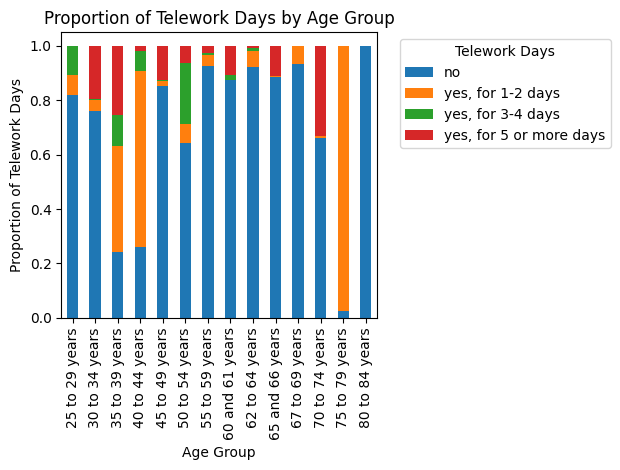

<Figure size 1000x600 with 0 Axes>

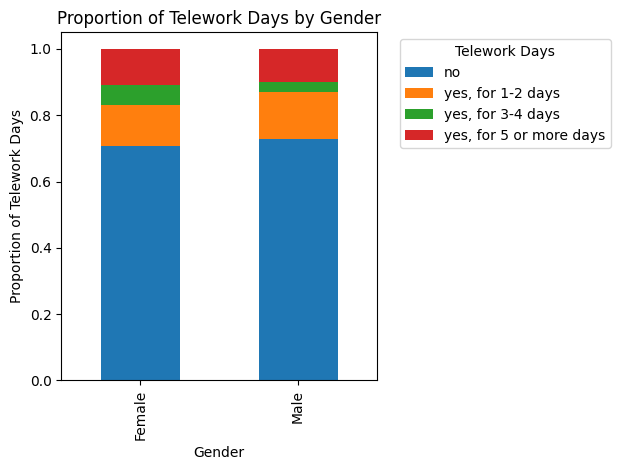

<Figure size 1000x600 with 0 Axes>

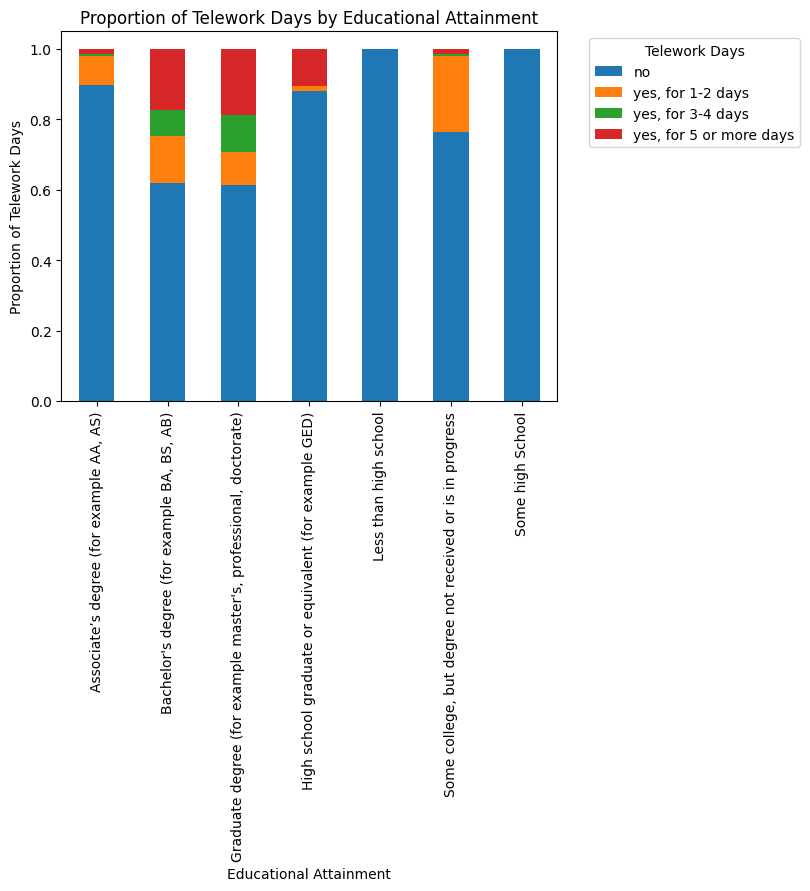

<Figure size 1000x600 with 0 Axes>

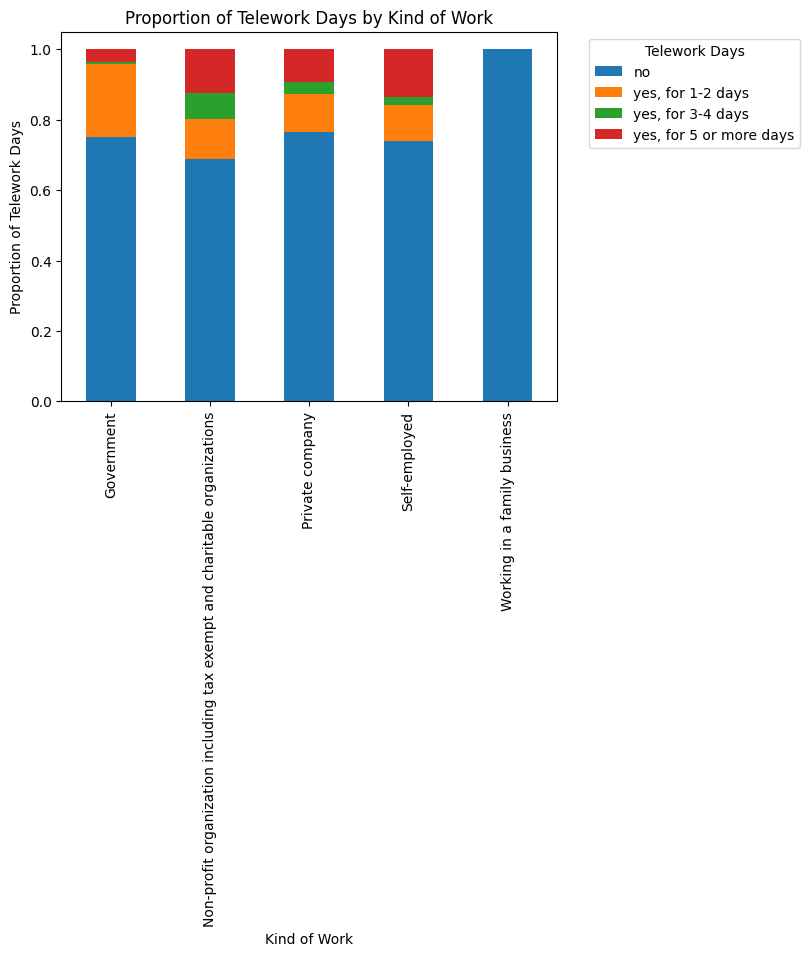

<Figure size 1000x600 with 0 Axes>

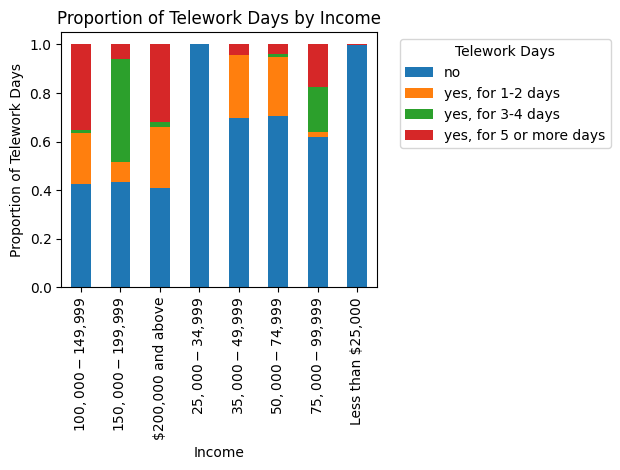

In [361]:
# Visualization for telework days by age group
plt.figure(figsize=(10, 6))
age_twday_proportion.plot(kind='bar', stacked=True)
plt.title('Proportion of Telework Days by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion of Telework Days')
plt.xticks(rotation=90)
plt.legend(title='Telework Days', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization for telework days by gender
plt.figure(figsize=(10, 6))
gender_twday_proportion.plot(kind='bar', stacked=True)
plt.title('Proportion of Telework Days by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion of Telework Days')
plt.legend(title='Telework Days', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization for telework days by educational attainment
plt.figure(figsize=(10, 6))
education_twday_proportion.plot(kind='bar', stacked=True)
plt.title('Proportion of Telework Days by Educational Attainment')
plt.xlabel('Educational Attainment')
plt.ylabel('Proportion of Telework Days')
plt.xticks(rotation=90)
plt.legend(title='Telework Days', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization for telework days by kind of work
plt.figure(figsize=(10, 6))
kindwork_twday_proportion.plot(kind='bar', stacked=True)
plt.title('Proportion of Telework Days by Kind of Work')
plt.xlabel('Kind of Work')
plt.ylabel('Proportion of Telework Days')
plt.xticks(rotation=90)
plt.legend(title='Telework Days', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization for telework days by income
plt.figure(figsize=(10, 6))
income_twday_proportion.plot(kind='bar', stacked=True)
plt.title('Proportion of Telework Days by Income')
plt.xlabel('Income')
plt.ylabel('Proportion of Telework Days')
plt.xticks(rotation=90)
plt.legend(title='Telework Days', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()